In [4]:
pip install numpy pandas yfinance matplotlib scikit-learn tensorflow

In [5]:
import yfinance as yf
import pandas as pd

# Download Bitcoin data
data = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')

# We only care about the 'Close' price for this simple model
df = data[['Close']]
print(df.tail())

/tmp/ipython-input-200379052.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed

Price              Close
Ticker           BTC-USD
Date                    
2024-12-27  94164.859375
2024-12-28  95163.929688
2024-12-29  93530.226562
2024-12-30  92643.210938
2024-12-31  93429.203125


In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Create sequences (e.g., use past 60 days to predict day 61)
prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape for LSTM [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2)) # Prevent overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Prediction layer
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and save the training history
# validation_split=0.1 means 10% of data is used to "quiz" the model during training
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0427 - val_loss: 0.0030
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 12/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0011 - val_l

/tmp/ipython-input-987288640.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download('BTC-USD', start=test_start, end=test_end)
[*********************100%***********************]  1 of 1 completed


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


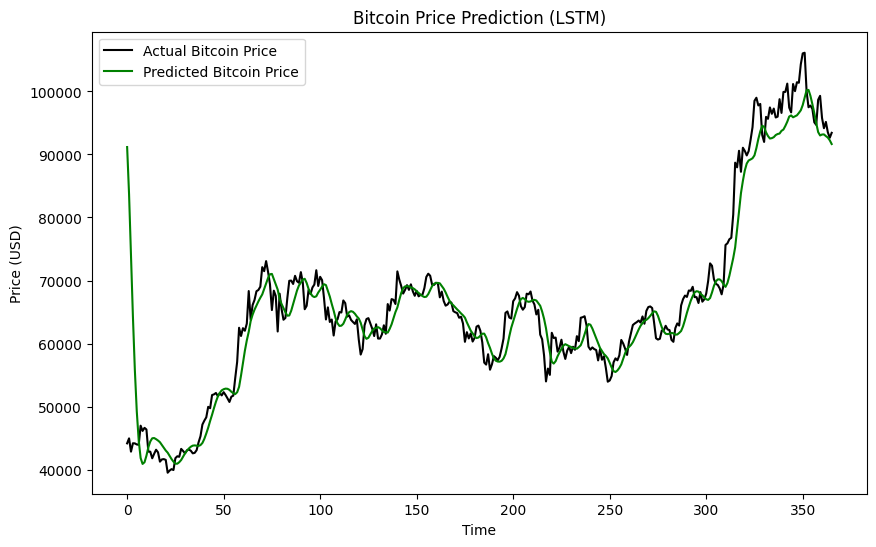

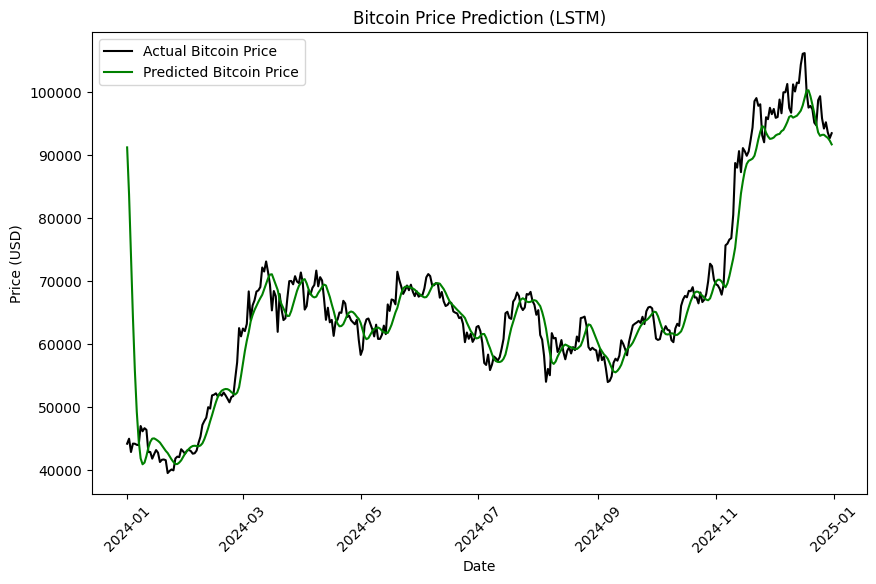

In [8]:
# 1. Get the Test Data (e.g., the data we didn't train on, or recent data)
# Let's test on the last 1 year of data to see how well it performs
test_start = '2024-01-01'
test_end = '2025-01-01'

test_data = yf.download('BTC-USD', start=test_start, end=test_end)
actual_prices = test_data['Close'].values

# 2. Prepare the Input for the Model
# We need the last 60 days from the TRAINING set to predict the 1st day of the TEST set
dataset_total = pd.concat((data['Close'], test_data['Close']), axis=0)

# Get the inputs: range is [len(total) - len(test) - 60] to the end
inputs = dataset_total[len(dataset_total) - len(test_data) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs) # Scale the test inputs just like the training data

x_test = []

for x in range(60, len(inputs)):
    x_test.append(inputs[x-60:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 3. Make Predictions
predicted_prices = model.predict(x_test)

# 4. Inverse Transform (Convert 0-1 scale back to Dollars)
predicted_prices = scaler.inverse_transform(predicted_prices)

# 5. Plot the Results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='black', label='Actual Bitcoin Price')
plt.plot(predicted_prices, color='green', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# 6. Plot the Results
plt.figure(figsize=(10, 6))

# CHANGE 1: Pass 'test_data.index' as the first argument for both plots
plt.plot(test_data.index, actual_prices, color='black', label='Actual Bitcoin Price')
plt.plot(test_data.index, predicted_prices, color='green', label='Predicted Bitcoin Price')

plt.title('Bitcoin Price Prediction (LSTM)')
plt.xlabel('Date') # Updated label
plt.ylabel('Price (USD)')
plt.legend()

# CHANGE 2: Rotate the date labels so they don't overlap
plt.xticks(rotation=45)

plt.show()

/tmp/ipython-input-3125474063.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download('BTC-USD', start=test_start, end=test_end)
[*********************100%***********************]  1 of 1 completed

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


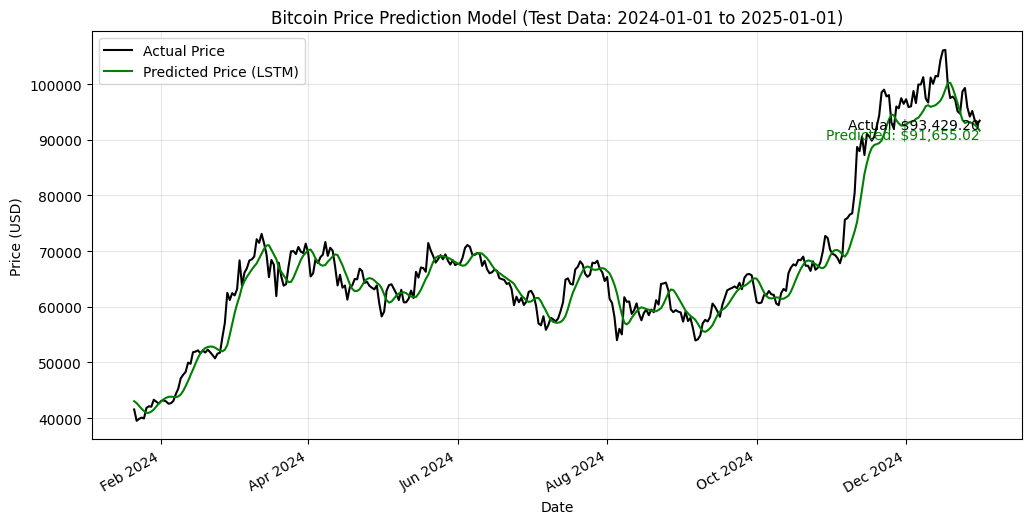

In [24]:
import yfinance as yf
import pandas as pd

# 1. Get the Test Data (e.g., the data we didn't train on, or recent data)
# Let's test on the last 1 year of data to see how well it performs
test_start = '2024-01-01'
test_end = '2025-01-01'

test_data = yf.download('BTC-USD', start=test_start, end=test_end)
actual_prices = test_data['Close'].values

# 2. Prepare the Input for the Model
# We need the last 60 days from the TRAINING set to predict the 1st day of the TEST set
dataset_total = pd.concat((data['Close'], test_data['Close']), axis=0)

# Get the inputs: range is [len(total) - len(test) - 60] to the end
inputs = dataset_total[len(dataset_total) - len(test_data) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs) # Scale the test inputs just like the training data

x_test = []

for x in range(60, len(inputs)):
    x_test.append(inputs[x-60:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 3. Make Predictions
predicted_prices = model.predict(x_test)

# 4. Inverse Transform (Convert 0-1 scale back to Dollars)
predicted_prices = scaler.inverse_transform(predicted_prices)

# 5. Plot the Results
# Create a DataFrame for plotting to handle dates easily
# Flatten both arrays to ensure they are 1D (fixes the Shape (366, 1) error)
# We use .flatten() on both just to be safe
plot_data = pd.DataFrame(
    {
        'Actual': actual_prices.flatten(),
        'Predicted': predicted_prices.flatten()
    },
    index=test_data.index
)

# Remove the first 20 days to hide the "warm-up" spike (optional but recommended)
plot_data = plot_data.iloc[20:]

# Plot with Dates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(plot_data['Actual'], color='black', label='Actual Price', linewidth=1.5)
plt.plot(plot_data['Predicted'], color='green', label='Predicted Price (LSTM)', linewidth=1.5)

plt.title(f'Bitcoin Price Prediction Model (Test Data: {test_start} to {test_end})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format the date on X-axis to look professional
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gcf().autofmt_xdate()

# Add text annotations for the last actual and predicted prices
last_date = plot_data.index[-1]
last_actual = plot_data['Actual'].iloc[-1]
last_predicted = plot_data['Predicted'].iloc[-1]

y_offset = -2000 # Adjust this value to move the text lower or higher

plt.text(last_date, last_actual + y_offset, f'Actual: ${last_actual:,.2f}', color='black', ha='right', va='bottom')
plt.text(last_date, last_predicted + y_offset, f'Predicted: ${last_predicted:,.2f}', color='green', ha='right', va='bottom')

plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure the arrays are 1-dimensional (flat) before calculating
# This prevents shape mismatch errors
y_true = actual_prices.flatten()
y_pred = predicted_prices.flatten()

# 1. Mean Absolute Error (MAE)
# "On average, how many dollars is the model off by?"
mae = mean_absolute_error(y_true, y_pred)

# 2. Root Mean Squared Error (RMSE)
# "Penalizes large errors more heavily (useful for volatile assets like Bitcoin)"
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 3. Mean Absolute Percentage Error (MAPE)
# "What is the average error in percentage terms?"
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"--- Model Performance Metrics ---")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

--- Model Performance Metrics ---
Mean Absolute Error (MAE): $2737.83
Root Mean Squared Error (RMSE): $4871.95
Mean Absolute Percentage Error (MAPE): 4.43%


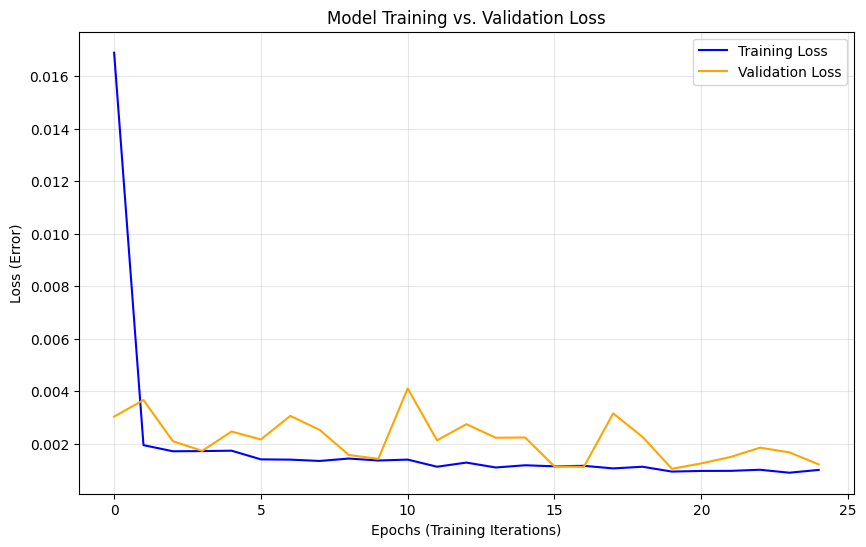

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot training loss (Blue)
plt.plot(history.history['loss'], label='Training Loss', color='blue')

# Plot validation loss (Orange)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

plt.title('Model Training vs. Validation Loss')
plt.xlabel('Epochs (Training Iterations)')
plt.ylabel('Loss (Error)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()